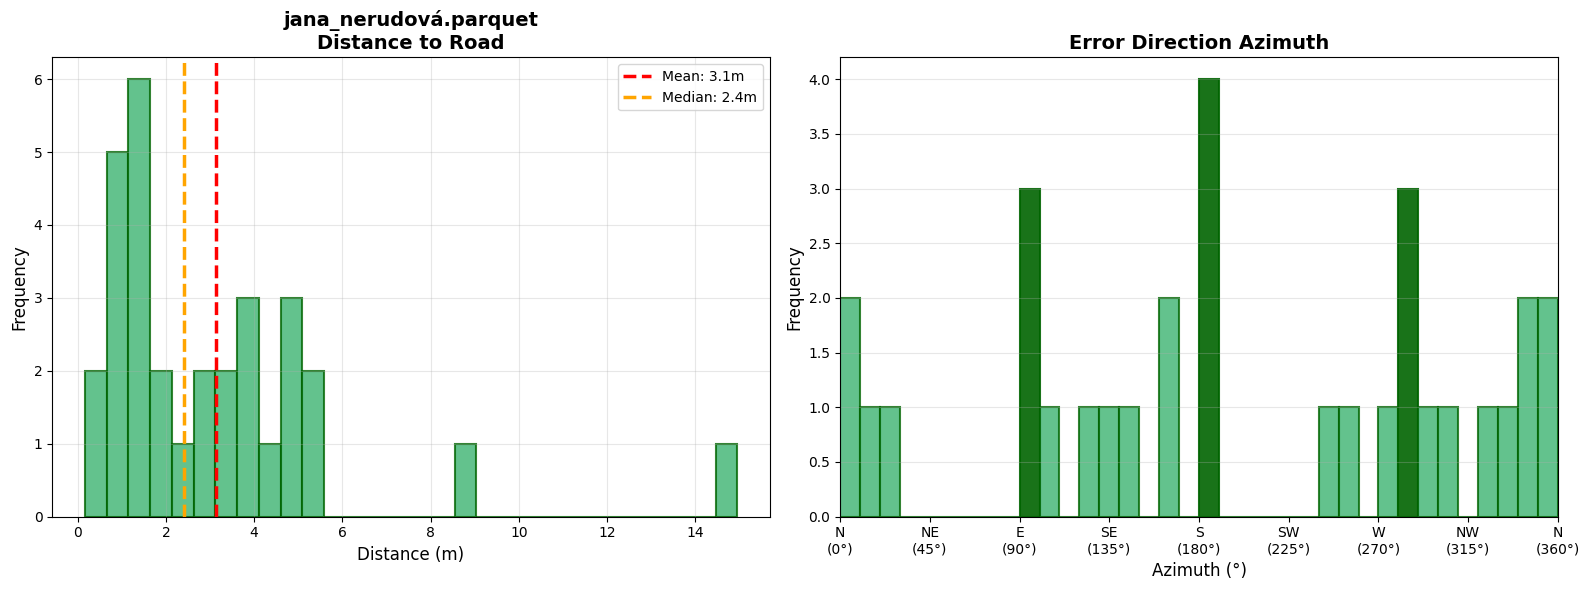

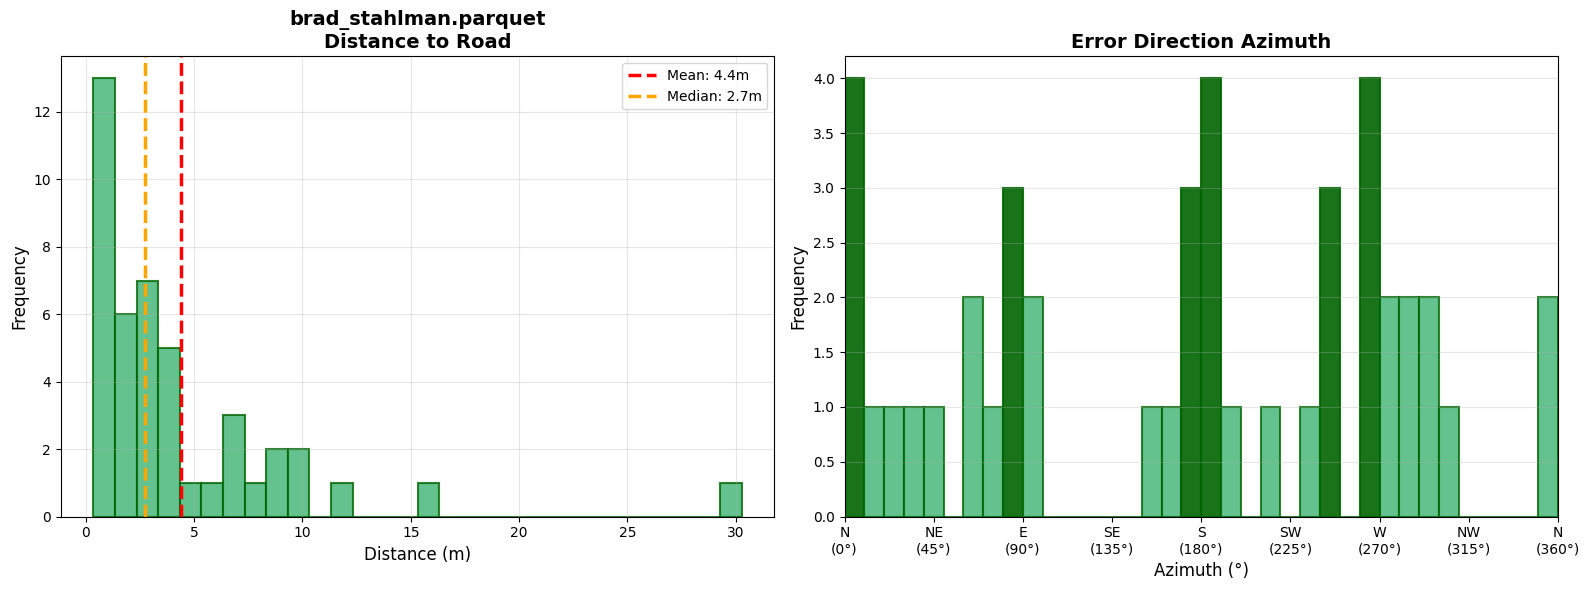

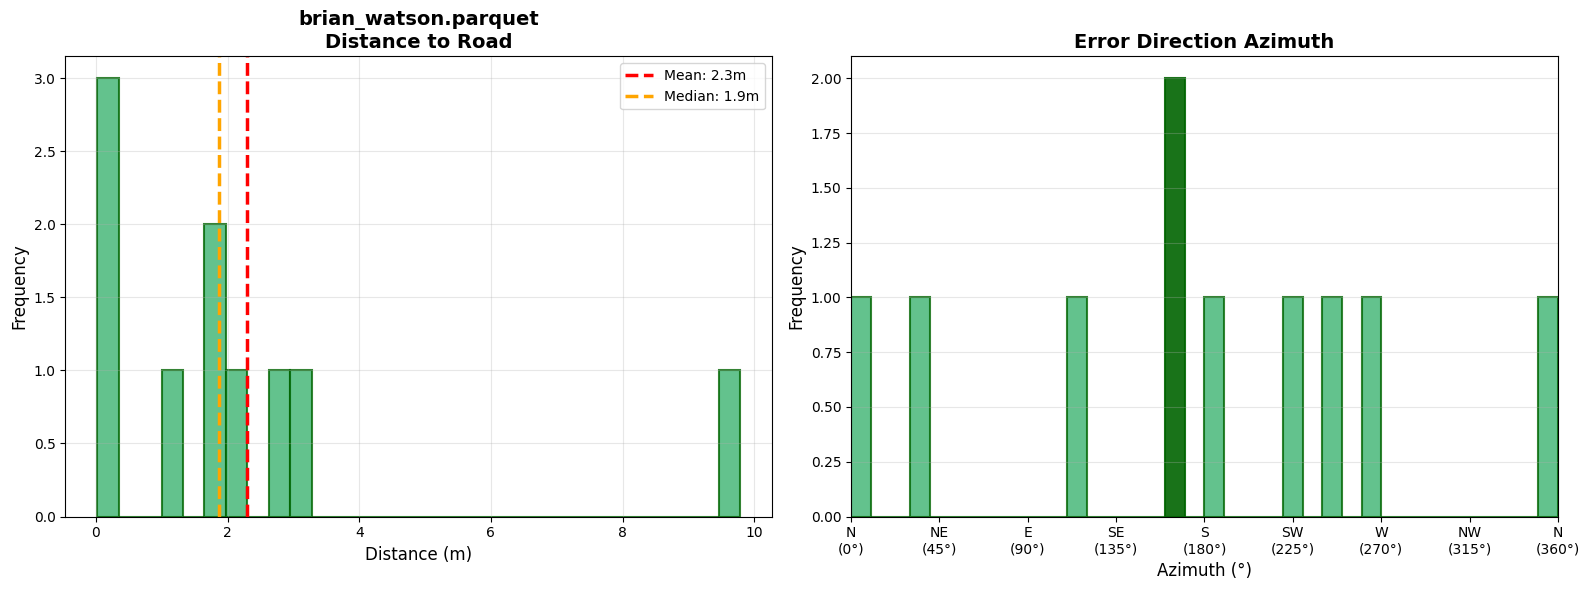

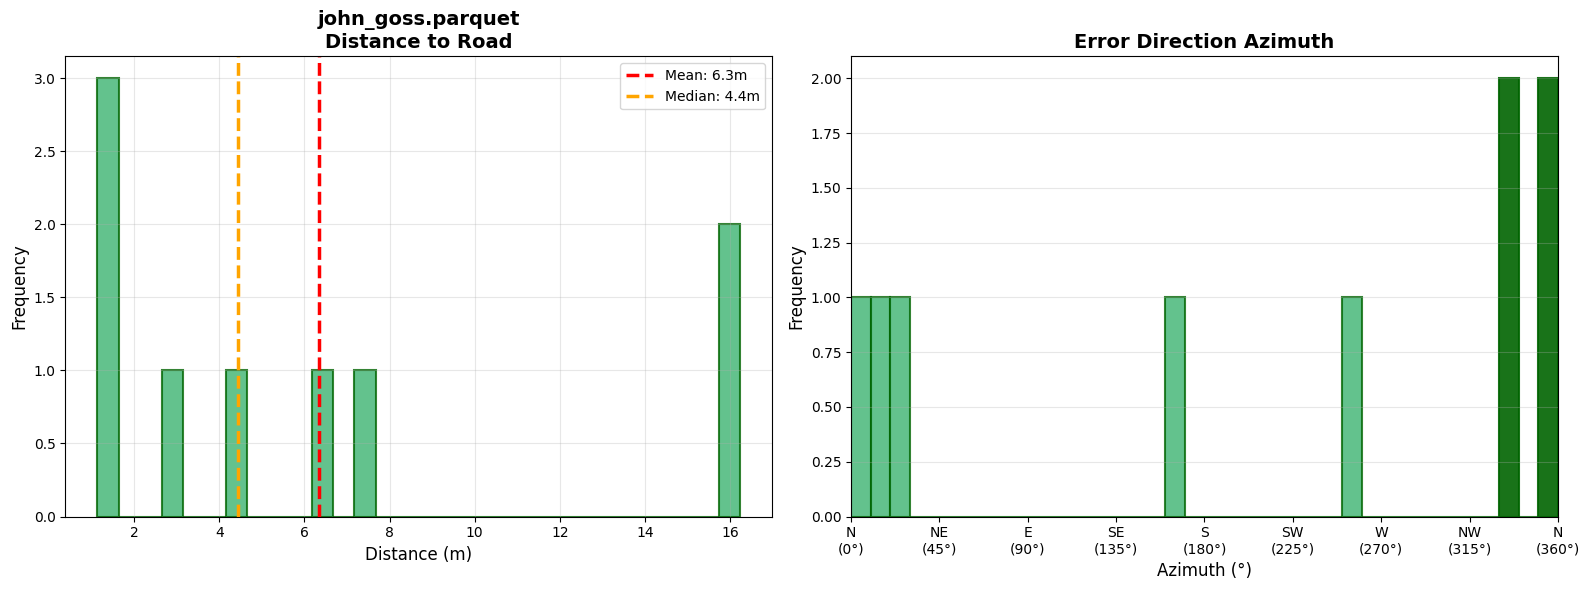

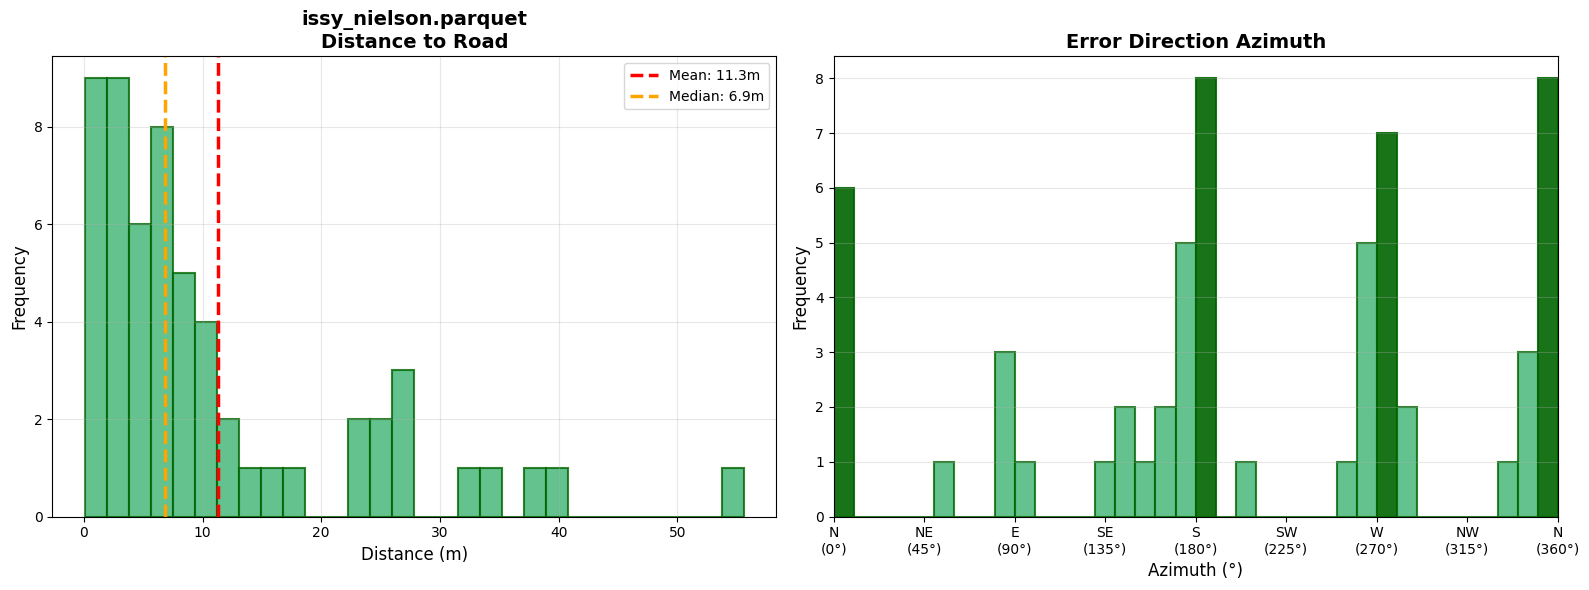

KeyboardInterrupt: 

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from math import radians, sin, cos, sqrt, asin, atan2, degrees
import requests
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import time
import random

# --- Configuration ---
content_dir = '/content'
parquet_files = [f for f in os.listdir(content_dir) if f.endswith('.parquet')]

# Sample 1 random point per track
POINTS_PER_TRACK = 1

# --- Helper functions ---
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in meters"""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1) * cos(phi2) * sin(dlambda/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

def calculate_azimuth(lat1, lon1, lat2, lon2):
    """Calculate azimuth (bearing) from point 1 to point 2 in degrees (0-360)"""
    lat1_rad = radians(lat1)
    lat2_rad = radians(lat2)
    dlon_rad = radians(lon2 - lon1)

    x = sin(dlon_rad) * cos(lat2_rad)
    y = cos(lat1_rad) * sin(lat2_rad) - sin(lat1_rad) * cos(lat2_rad) * cos(dlon_rad)

    azimuth = degrees(atan2(x, y))
    return (azimuth + 360) % 360  # Normalize to 0-360

def extract_route_coordinates(geometry):
    """Extract coordinates from geometry"""
    if geometry is None or geometry.is_empty:
        return None
    return [(coord[1], coord[0]) for coord in geometry.coords]

def get_osm_roads_overpass(lat, lon, radius=100):
    """Query OSM for roads near a point using Overpass API"""
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = f"""
    [out:json];
    (
      way["highway"](around:{radius},{lat},{lon});
    );
    out geom;
    """

    try:
        response = requests.get(overpass_url, params={'data': overpass_query}, timeout=30)
        data = response.json()

        roads = []
        if 'elements' in data:
            for element in data['elements']:
                if element['type'] == 'way' and 'geometry' in element:
                    coords = [(node['lat'], node['lon']) for node in element['geometry']]
                    if len(coords) >= 2:
                        roads.append(LineString([(lon, lat) for lat, lon in coords]))

        return roads
    except Exception as e:
        return []

def calculate_distance_and_azimuth_to_nearest_road(point_lat, point_lon, roads):
    """Calculate distance and azimuth from point to nearest road"""
    if not roads:
        return None, None

    point = Point(point_lon, point_lat)
    min_distance = float('inf')
    nearest_road_point = None

    for road in roads:
        try:
            _, road_point = nearest_points(point, road)
            dist = haversine_distance(point_lat, point_lon, road_point.y, road_point.x)
            if dist < min_distance:
                min_distance = dist
                nearest_road_point = road_point
        except:
            continue

    if nearest_road_point is None or min_distance == float('inf'):
        return None, None

    # Calculate azimuth from GPS point to nearest road point
    azimuth = calculate_azimuth(point_lat, point_lon,
                                nearest_road_point.y, nearest_road_point.x)

    return min_distance, azimuth

def sample_random_points(coords, n_points):
    """Sample n random points from track"""
    if not coords or len(coords) < n_points:
        return coords if coords else []

    # Exclude first and last points to avoid start/end locations
    if len(coords) > n_points + 2:
        middle_coords = coords[1:-1]
        indices = random.sample(range(len(middle_coords)), n_points)
        return [middle_coords[i] for i in sorted(indices)]
    else:
        indices = random.sample(range(len(coords)), min(n_points, len(coords)))
        return [coords[i] for i in sorted(indices)]

# --- Process each parquet file ---
for parquet_file in parquet_files:
    file_deviations = []
    file_azimuths = []

    file_path = os.path.join(content_dir, parquet_file)
    gdf = gpd.read_parquet(file_path)

    for track_idx, geom in enumerate(gdf.geometry):
        coords = extract_route_coordinates(geom)
        if not coords or len(coords) < 2:
            continue

        # Sample 1 random point from track
        sampled_points = sample_random_points(coords, POINTS_PER_TRACK)

        for lat, lon in sampled_points:
            # Query OSM for nearby roads
            roads = get_osm_roads_overpass(lat, lon, radius=100)

            if roads:
                distance, azimuth = calculate_distance_and_azimuth_to_nearest_road(lat, lon, roads)
                if distance is not None and azimuth is not None:
                    file_deviations.append(distance)
                    file_azimuths.append(azimuth)

            # Rate limiting
            time.sleep(0.5)

    # Convert to numpy arrays
    if not file_deviations:
        continue

    file_deviations = np.array(file_deviations)
    file_azimuths = np.array(file_azimuths)

    # --- Visualization for this file ---
    fig = plt.figure(figsize=(16, 6))

    # 1. Distance distribution histogram
    ax1 = plt.subplot(1, 2, 1)
    ax1.hist(file_deviations, bins=30, alpha=0.8, edgecolor='darkgreen', color='mediumseagreen', linewidth=1.5)
    ax1.axvline(np.mean(file_deviations), color='red', linestyle='--', linewidth=2.5,
                label=f'Mean: {np.mean(file_deviations):.1f}m')
    ax1.axvline(np.median(file_deviations), color='orange', linestyle='--', linewidth=2.5,
                label=f'Median: {np.median(file_deviations):.1f}m')
    ax1.set_title(f'{parquet_file}\nDistance to Road', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Distance (m)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    # 2. Azimuth distribution (bar chart)
    ax2 = plt.subplot(1, 2, 2)

    # Create histogram bins
    n_bins = 36  # 10-degree bins
    bins = np.linspace(0, 360, n_bins + 1)
    counts, bin_edges = np.histogram(file_azimuths, bins=bins)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Create bar chart
    bars = ax2.bar(bin_centers, counts, width=360/n_bins, alpha=0.8,
                   edgecolor='darkgreen', color='mediumseagreen', linewidth=1.5)

    # Highlight dominant directions if any
    max_count = np.max(counts)
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > max_count * 0.7:  # Highlight bars with >70% of max
            bar.set_color('darkgreen')
            bar.set_alpha(0.9)

    ax2.set_title('Error Direction Azimuth', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Azimuth (°)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_xlim(0, 360)
    ax2.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
    ax2.set_xticklabels(['N\n(0°)', 'NE\n(45°)', 'E\n(90°)', 'SE\n(135°)',
                         'S\n(180°)', 'SW\n(225°)', 'W\n(270°)', 'NW\n(315°)', 'N\n(360°)'])
    ax2.grid(alpha=0.3, axis='y')

    plt.tight_layout()

    output_path = os.path.join(content_dir, f'gpx_validation_{parquet_file.replace(".parquet", "")}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()